In [47]:
# For dates
import datetime as dt
from dateutil.relativedelta import relativedelta

# For data analysis
import dtale
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# External resources
from yahoo_fin.stock_info import get_data

In [35]:
%matplotlib inline

First, we would obtain the data for one company and analyze it.

Then, once we know how this is done manually, we will automate this extraction.

This data will be stored in our database, as well as in a S3 bucket.

# Amazon Prices Weekly

In [22]:
# If we have no data of the company, we extract last 5 years
to_substract = datetime.date.today() - relativedelta(years=5)

In [23]:
amazon_weekly= get_data(
    "amzn", 
    start_date=to_substract, 
    index_as_date = True, 
    interval="1wk")

In [40]:
dtale.show(amazon_weekly)

/home/nil/Documents/Projects/forecasting-app/injestion/venv/lib/python3.10/site-packages/dtale/views.py:832: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [25]:
# We will now make an analysis of this data
amazon_weekly.describe()

,open,high,low,close,adjclose,volume
count,262.000000,262.000000,262.000000,262.000000,262.000000,2.620000e+02
mean,116.820800,120.738273,113.287063,117.129924,117.129924,4.137479e+08
std,38.259867,39.419543,37.055965,38.007134,38.007134,1.647041e+08
min,47.465500,48.241501,46.587502,48.067501,48.067501,6.512666e+07
25%,86.664873,89.355497,84.378748,87.058374,87.058374,2.948200e+08
50%,101.662498,106.993248,100.636250,104.381248,104.381248,3.738240e+08
75%,158.342628,162.365379,153.639381,157.947376,157.947376,5.017265e+08
max,187.199997,188.654007,178.522995,185.966995,185.966995,1.048892e+09


### Handling NaNs

In [28]:
# Check if there are any null values
amazon_weekly.isnull().sum(axis=0)

open        0
high        0
low         0
close       0
adjclose    0
volume      0
ticker      0
dtype: int64

In [39]:
# We would not know if for some company we would have any null value, and is something we would have to handle
if amazon_weekly.isnull().any().sum() != 0:
    
    # We wou'ld fill the na with the last valid value
    amazon_weekly.fillna(method="backfill")

In [70]:
# A function would be like the following
def handle_nan(df, method="backfill"):
    
    return df.fillna(method=method)

### Visualize Evolution

Text(0, 0.5, 'Price in $')

findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'Heiti TC'

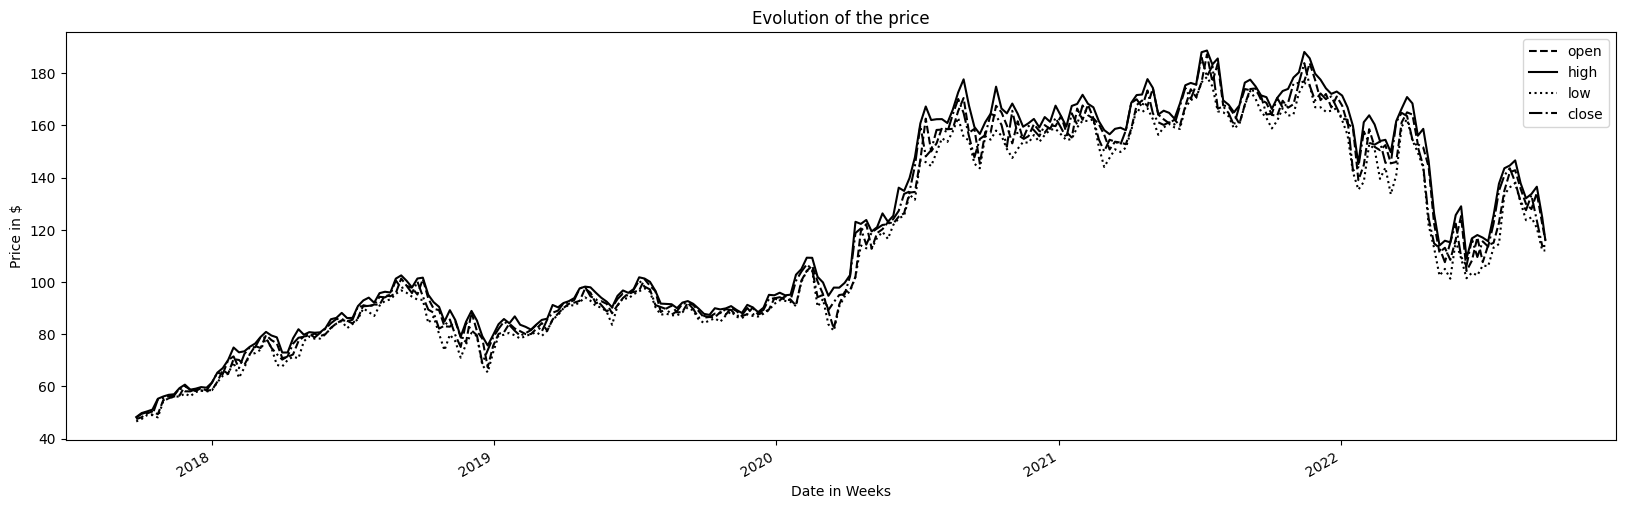

In [36]:
# We can make a plot of the evolution of the prices
amazon_weekly["open"].plot(figsize=(20,6), linestyle="--", color="black", legend="Open Price of Week")
amazon_weekly["high"].plot(figsize=(20,6), linestyle="-", color="black", legend="High Price of Week")
amazon_weekly["low"].plot(figsize=(20,6), linestyle=":", color="black", legend="Low Price of Week")
amazon_weekly["close"].plot(figsize=(20,6), linestyle="-.", color="black", legend="Close Price of Week")

plt.title("Evolution of the price")
plt.xlabel("Date in Weeks")
plt.ylabel("Price in $ of each Share")

### Handling Outliers

In this case we do not have outliers, but it is one scenario we would have to handle.

There are two ways to check for outliers:
- **Inter-Quantile Range**: we use extreme percentil values, of 5% and 95%, to minimize risk of removing correct data points.
- **Z-Score**: represents the distance of the data point in the number of standard deviations away from mean. For a large dataset, for the rule of large numbers, there is 1% chance of a data point having a value of >= 3.

In [45]:
# We will use stats to compute the z-score
prices_amazon = amazon_weekly.drop(["adjclose", "volume", "ticker"], axis=1)

In [51]:
# We can compute the Z-Score in the following way
stats.zscore(prices_amazon)

,open,high,low,close
2017-09-25,-1.816212,-1.842627,-1.803413,-1.820569
2017-10-02,-1.796978,-1.803333,-1.778241,-1.783360
2017-10-09,-1.758692,-1.787206,-1.738049,-1.765751
2017-10-16,-1.738790,-1.769580,-1.737860,-1.792151
2017-10-23,-1.767216,-1.663757,-1.761843,-1.636568
...,...,...,...,...
2022-08-29,0.342506,0.288015,0.280462,0.273631
2022-09-05,0.290656,0.329190,0.309663,0.425472
2022-09-12,0.452492,0.400357,0.200430,0.168714
2022-09-19,0.139818,0.100948,-0.033177,-0.088308


In [67]:
# And now we can see if some absolute value of z-score is higher than 3 (would be a parameter of sensibility)
prices_amazon[(np.abs(stats.zscore(prices_amazon)) > 3).all(axis=1)]

,open,high,low,close


In [68]:
# And in the case of outliers, we would remove them by index
prices_amazon_cleaned = prices_amazon.\
    drop(prices_amazon[(np.abs(stats.zscore(prices_amazon)) > 3).all(axis=1)].index)
prices_amazon_cleaned

,open,high,low,close
2017-09-25,47.465500,48.241501,46.587502,48.067501
2017-10-02,48.200001,49.787498,47.518501,49.479000
2017-10-09,49.661999,50.422001,49.005001,50.146999
2017-10-16,50.422001,51.115501,49.012001,49.145500
2017-10-23,49.336498,55.278999,48.125000,55.047501
...,...,...,...,...
2022-08-29,129.899994,132.070007,123.660004,127.510002
2022-09-05,127.919998,133.690002,124.739998,133.270004
2022-09-12,134.100006,136.490005,120.699997,123.529999
2022-09-19,122.160004,124.709999,112.059998,113.779999


In [69]:
# So the function would be the following
def clean_outliers_z_score(df, threshold):
    return df.drop(df[(np.abs(stats.zscore(df)) > threshold).all(axis=1)].index)

### Univariate Analysis

In [79]:
# Next thing to do, is to make an univariate and bivariate analysis
delta_prices = prices_amazon_cleaned.shift(-1) - prices_amazon_cleaned
delta_prices = delta_prices.fillna(0)
delta_prices.columns = ["Delta Open", "Delta High", "Delta Low", "Delta Close"]
delta_prices

,Delta Open,Delta High,Delta Low,Delta Close
2017-09-25,0.734501,1.545998,0.931000,1.411499
2017-10-02,1.461998,0.634502,1.486500,0.667999
2017-10-09,0.760002,0.693501,0.007000,-1.001499
2017-10-16,-1.085503,4.163498,-0.887001,5.902000
2017-10-23,5.414001,0.860500,6.218498,0.532501
...,...,...,...,...
2022-08-29,-1.979996,1.619995,1.079994,5.760002
2022-09-05,6.180008,2.800003,-4.040001,-9.740005
2022-09-12,-11.940002,-11.780006,-8.639999,-9.750000
2022-09-19,-6.160004,-8.659996,0.000000,0.000000


In [80]:
delta_prices.describe()

,Delta Open,Delta High,Delta Low,Delta Close
count,262.000000,262.000000,262.000000,262.000000
mean,0.261582,0.258811,0.249895,0.250811
std,5.749655,5.079456,5.032123,5.331493
min,-21.621994,-20.000999,-22.072495,-20.068504
25%,-2.305378,-2.000250,-1.597502,-2.322878
50%,0.404503,0.453751,0.518505,0.296249
75%,3.487503,2.643501,2.583998,2.952876
max,17.497498,20.400002,18.979996,16.612000


<AxesSubplot: ylabel='Frequency'>

2022-09-26 12:09:28,077 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:28,080 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:28,082 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:28,085 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:28,089 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:28,092 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:28,094 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:28,097 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:28,100 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:28,103 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:28,106 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:28,109 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:28,112 - WA

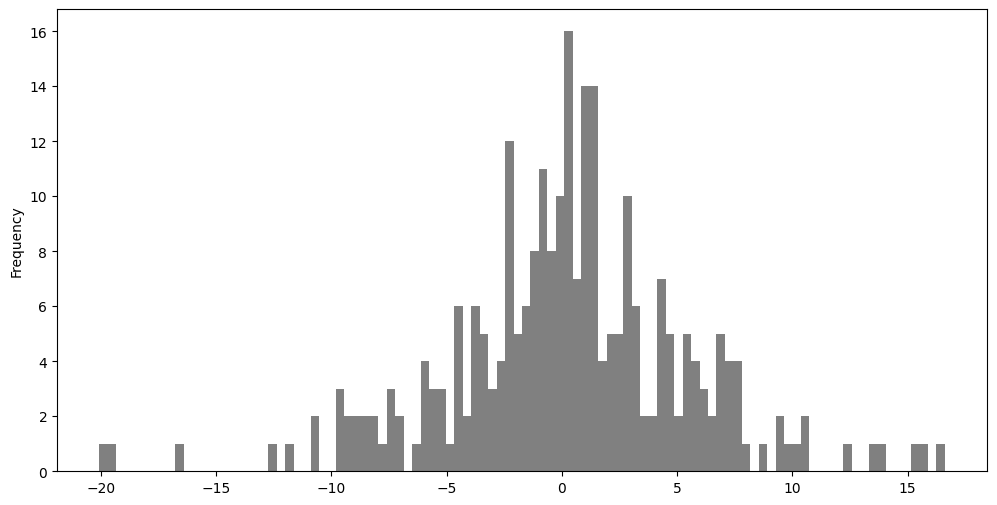

In [85]:
delta_prices["Delta Close"].plot(kind="hist", bins=100, figsize=(12, 6), color="gray")

We could see that the delta means are approximately around 0 in absolute values, but +

In [82]:
# Next thing to do, is to make an univariate and bivariate analysis
delta_prices_perc = (prices_amazon_cleaned.shift(-1) - prices_amazon_cleaned) / prices_amazon_cleaned.shift(-1)
delta_prices_perc = delta_prices_perc.fillna(0)
delta_prices_perc.columns = ["Delta Open Perc", "Delta High Perc", "Delta Low Perc", "Delta Close Perc"]
delta_prices_perc

,Delta Open Perc,Delta High Perc,Delta Low Perc,Delta Close Perc
2017-09-25,0.015239,0.031052,0.019592,0.028527
2017-10-02,0.029439,0.012584,0.030334,0.013321
2017-10-09,0.015073,0.013567,0.000143,-0.020378
2017-10-16,-0.022002,0.075318,-0.018431,0.107217
2017-10-23,0.098885,0.015328,0.114429,0.009581
...,...,...,...,...
2022-08-29,-0.015478,0.012118,0.008658,0.043221
2022-09-05,0.046085,0.020514,-0.033471,-0.078847
2022-09-12,-0.097741,-0.094459,-0.077102,-0.085692
2022-09-19,-0.053103,-0.074623,0.000000,0.000000


In [83]:
# And now we would see that the mean is around +0.2%
delta_prices_perc.describe()

,Delta Open Perc,Delta High Perc,Delta Low Perc,Delta Close Perc
count,262.000000,262.000000,262.000000,262.000000
mean,0.002273,0.002542,0.002339,0.002339
std,0.047965,0.040292,0.045074,0.043648
min,-0.202131,-0.182744,-0.181480,-0.161476
25%,-0.022103,-0.019272,-0.015678,-0.023366
50%,0.004532,0.004414,0.005218,0.003236
75%,0.029429,0.024430,0.022219,0.029943
max,0.146426,0.165786,0.142162,0.139891


<AxesSubplot: ylabel='Frequency'>

2022-09-26 12:09:08,973 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:08,977 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:08,980 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:08,984 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:08,987 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:08,991 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:08,995 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:08,998 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:09,002 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:09,006 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:09,010 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:09,014 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:09:09,018 - WA

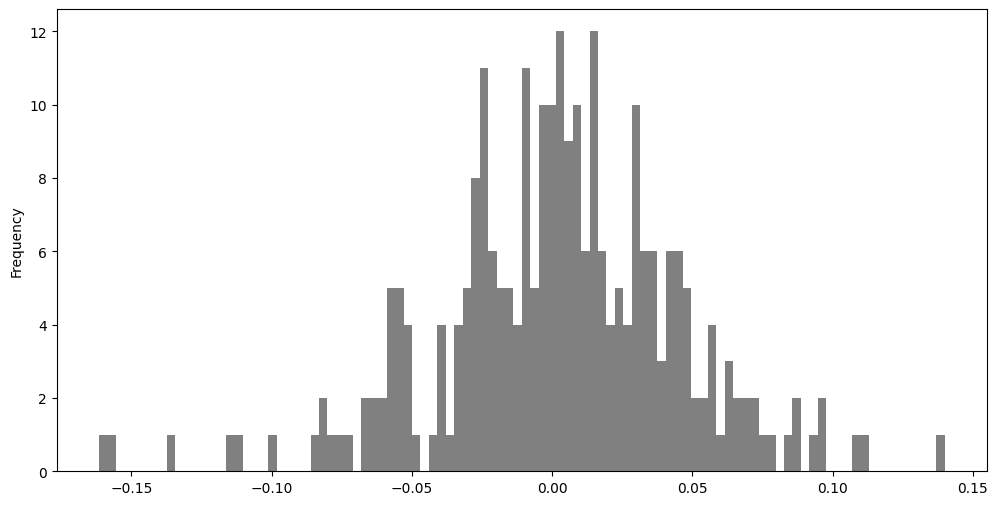

In [84]:
delta_prices_perc["Delta Close Perc"].plot(kind="hist", bins=100, figsize=(12, 6), color="gray")

<AxesSubplot: >

2022-09-26 12:25:16,554 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,556 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,558 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,570 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,573 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,576 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,580 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,583 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,586 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,589 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,593 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,596 - WARNING  - findfont: Font family 'Heiti TC' not found.
2022-09-26 12:25:16,599 - WA

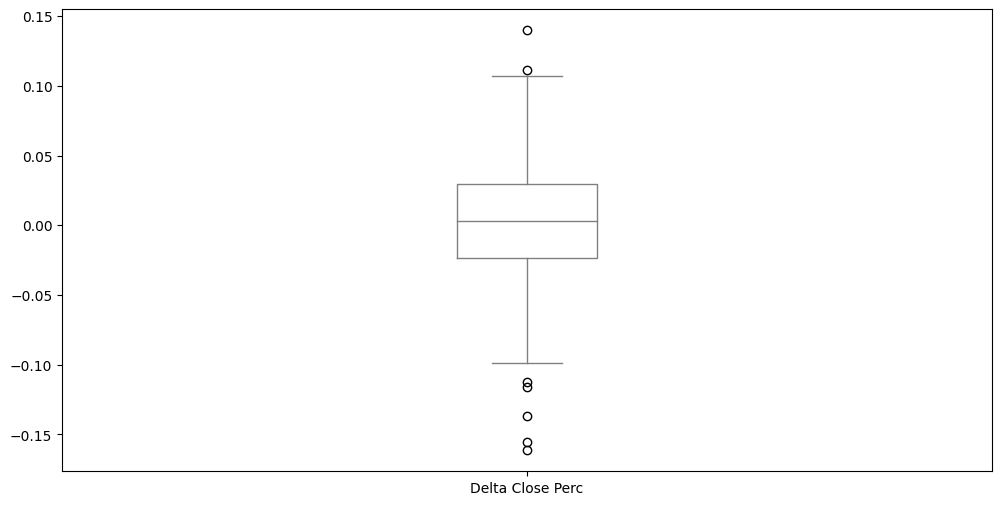

In [87]:
# We could also display a boxplot to know how it this variation
delta_prices_perc["Delta Close Perc"].plot(kind="box", figsize=(12, 6), color="gray")

### Bivariate Analysis

# S&P 500 Companies

In [88]:
# We can get the S&P500 companies by reading directly to the table of wikipedia
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

sp_companies = pd.read_html(wiki_url, header=0)[0]

sp_companies.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


- TODO: Remove outliers by inter-quantile range

- TODO: When computing delta_prices_perc, check for 0 in the divisor

- TODO: Install fonts for matplotlib
    - https://stackoverflow.com/questions/42097053/matplotlib-cannot-find-basic-fonts

- TODO: PCA to detect in each case, which features to use -> feature engineering.
    - https://medium.com/@data.science.enthusiast/feature-selection-techniques-forward-backward-wrapper-selection-9587f3c70cfa

